In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv('AirQualityUCI.csv', sep=';')
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [6]:
data['Date']=pd.to_datetime(data['Date'])

In [8]:
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',','.').astype('float')
        

In [9]:
# Compute the average considering only the positive values

def positive_average(num):
    return num[num>0].mean()

In [10]:
# Aggregate data
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)


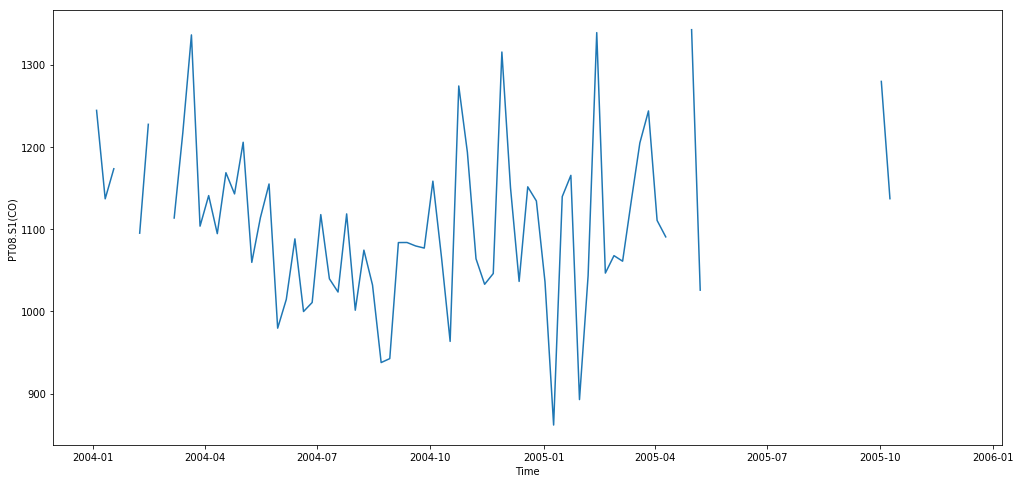

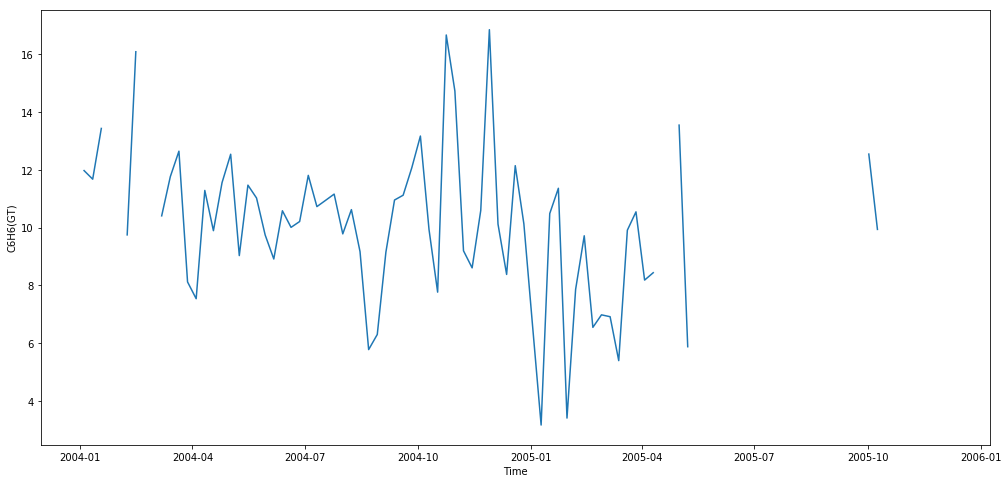

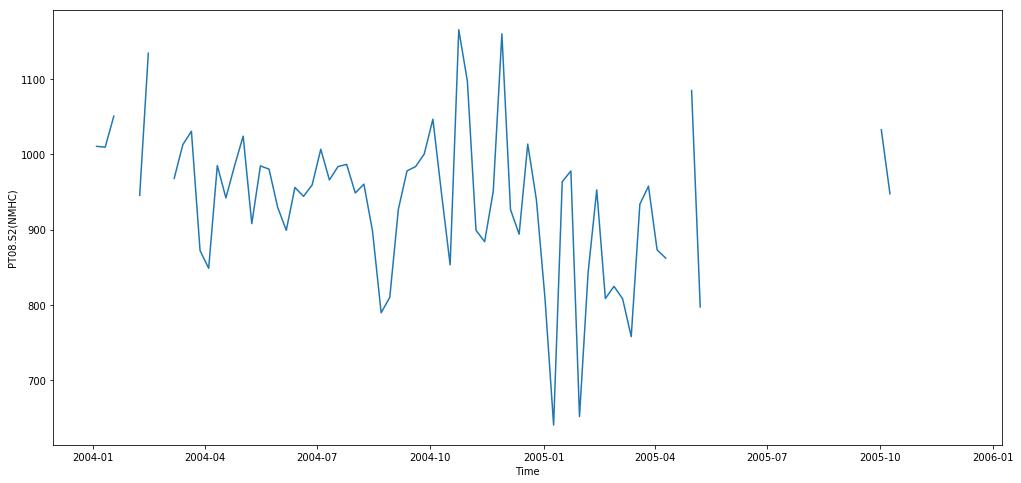

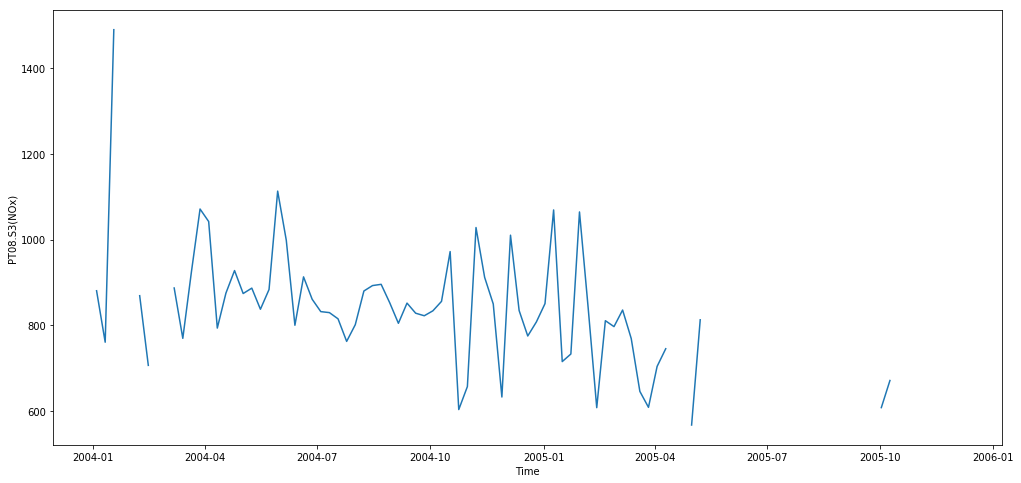

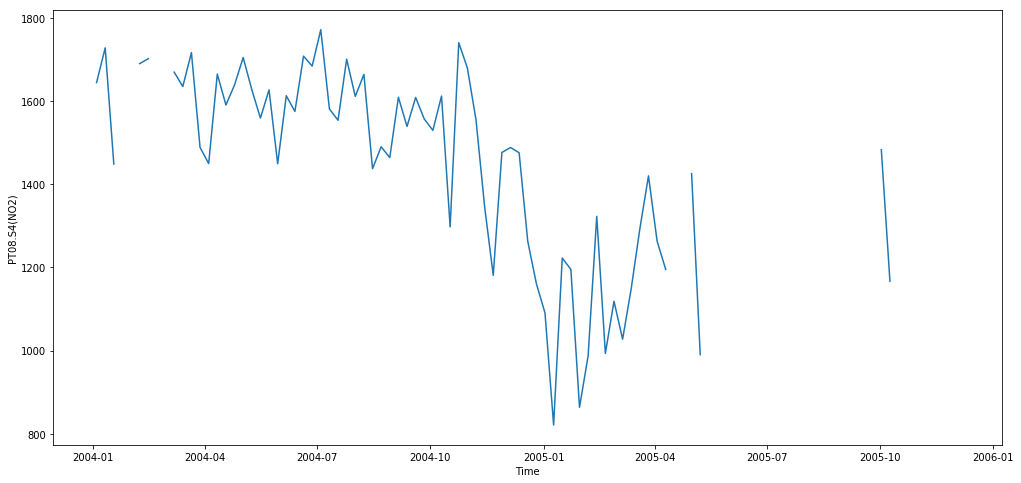

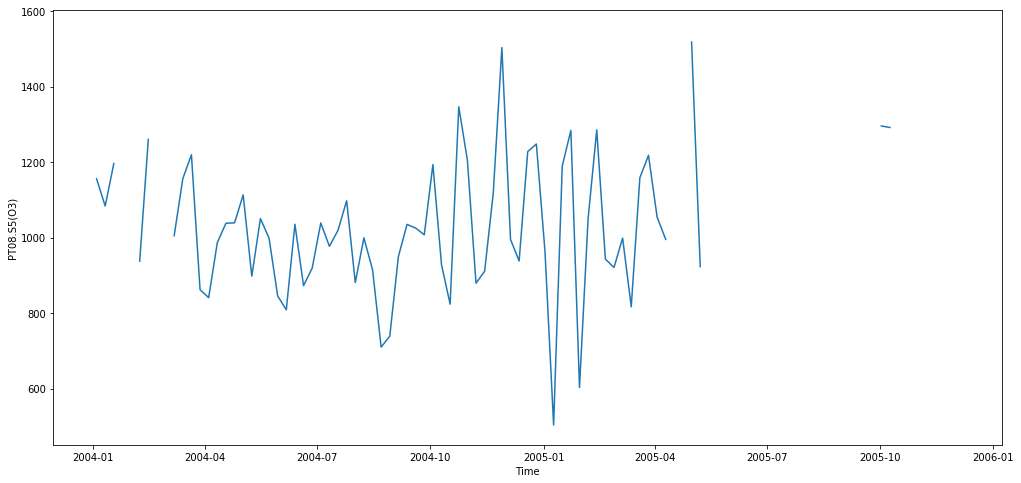

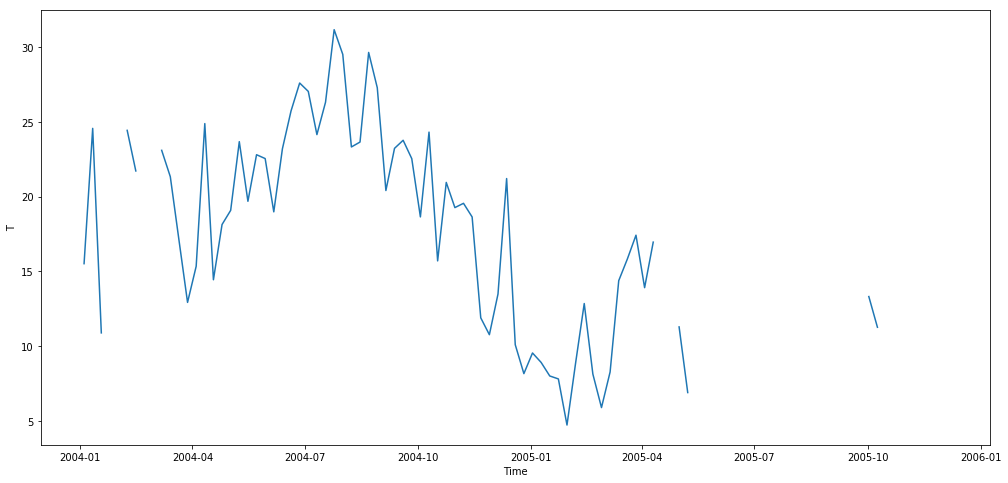

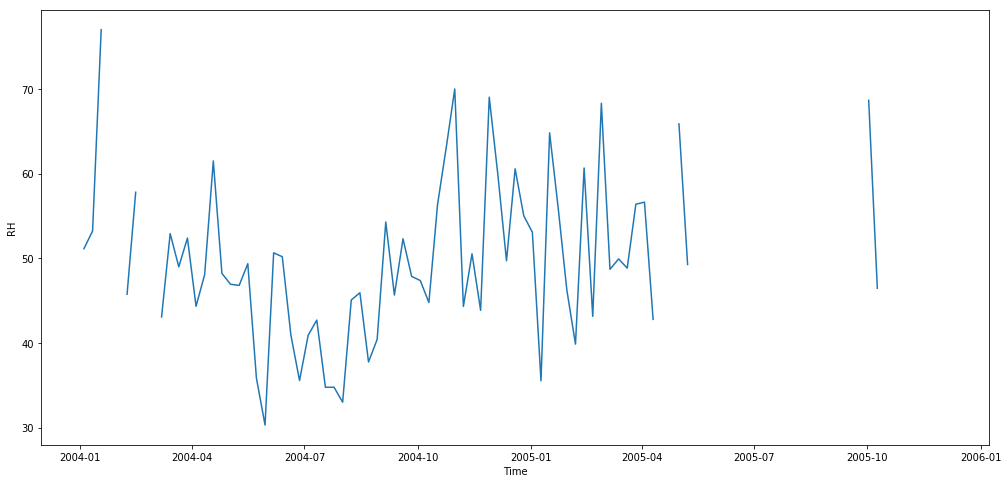

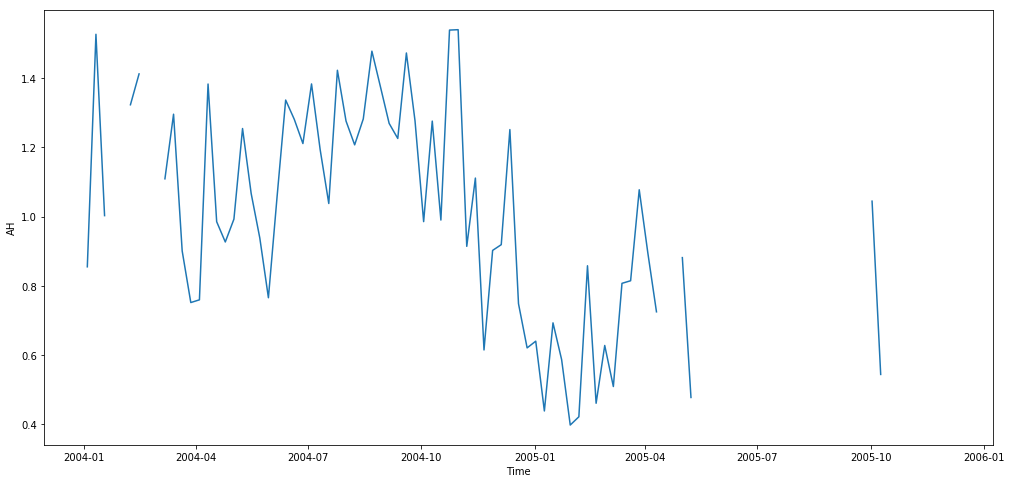

In [11]:
# Drop columns with more than 8 NaN
daily_data = daily_data.iloc[:,(daily_data.isna().sum() <= 8).values]

# Remove rows containing NaN values
daily_data = daily_data.dropna()

# Aggregate data by week
weekly_data = daily_data.resample('W').mean()

# Plot the weekly concentration of each gas
def plot_data(col):
    plt.figure(figsize=(17, 8))
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

In [12]:
#Modelling

In [13]:
# Drop irrelevant columns
cols_to_drop = ['PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']

weekly_data = weekly_data.drop(cols_to_drop, axis=1)

In [15]:
# Import Prophet
from fbprophet import Prophet
import logging

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [16]:
logging.getLogger().setLevel(logging.ERROR)

In [17]:
# Change the column names according to Prophet's guidelines
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2004-01-04,880.666667
1,2004-01-11,760.484990
2,2004-01-18,1490.333333
3,2004-01-25,NaN
4,2004-02-01,NaN


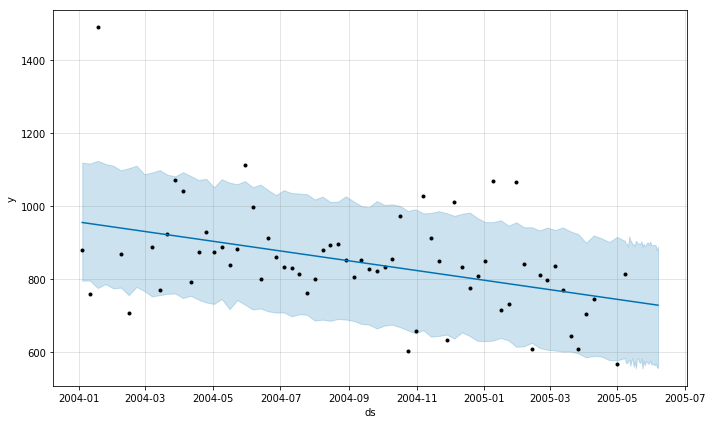

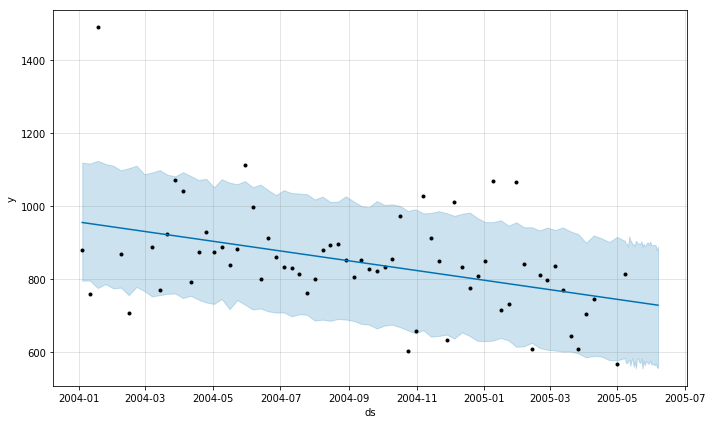

In [18]:
# Split into a train/test set
prediction_size = 30
train_df = df[:-prediction_size]

# Initialize and train a model
m = Prophet()
m.fit(train_df)

# Make predictions
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
forecast.head()

# Plot forecast
m.plot(forecast)

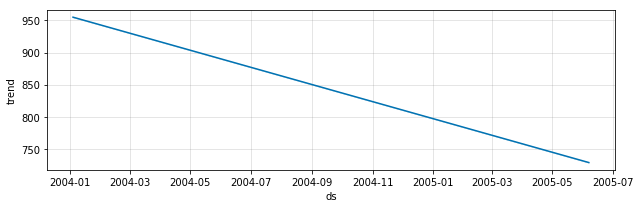

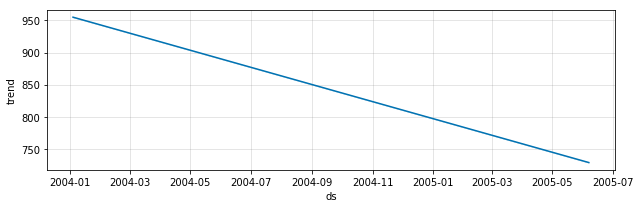

In [19]:
# Plot forecast's components
m.plot_components(forecast)

MAPE 20.11188526925137
MAE 183.6634122692426


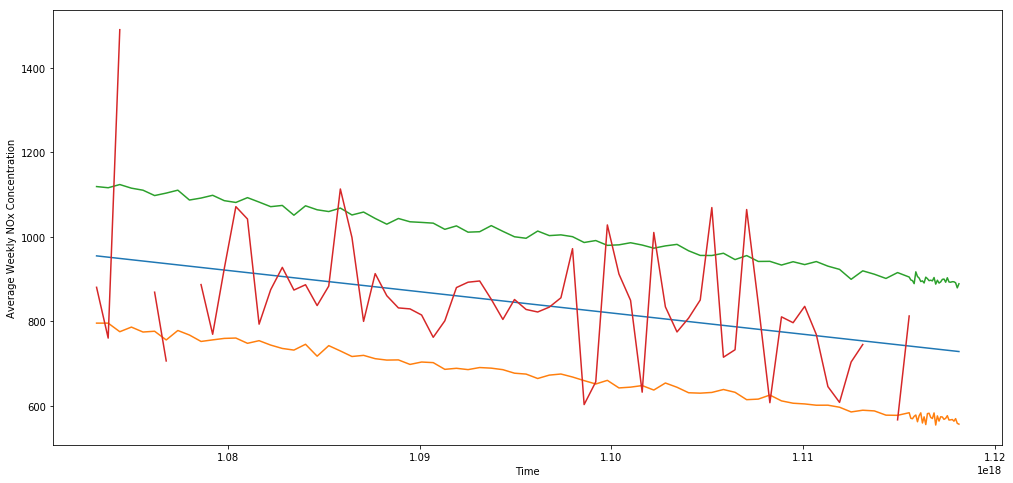

In [20]:
# Evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head()

def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

# Plot forecast with upper and lower bounds
plt.figure(figsize=(17, 8))
plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()